In [124]:
import matplotlib.pyplot as plt 
import numpy as np
import random 
import math
from mpl_toolkits import mplot3d
import pandas as pd
from itertools import zip_longest
import csv

# Mathematical Functions

In [125]:
def coeffGen(p,k):
    """
    Input: Lower limit and higher limit (int)
    Output: List of length K with random values between low and high
    """
    coeffSeq = []
    for i in range(k):
        # mean = a, var = b^2
        coeffSeq.append(np.random.normal(0, 1/(np.power(i+1, p))))
    return coeffSeq

def genTrigFun(a_k, b_k):
    """
    Input: 
    >> int list a_k, b_k: Sequences of length K
    
    Output: 
    >> fun f(t): Desired trig function with coefficients corresponding to sequences a_k, b_k
    """
    def fun_t (t):
        sum = 0
        for i in range(len(a_k)):
            sum += a_k[i]*np.sin(i*t) + b_k[i]*np.cos(i*t)
        return sum
    return (fun_t)

def euclidDist(a, b):
    return np.sqrt(np.power(a, 2) + np.power(b, 2))

def speed(x_t, y_t):
    """
    Input: 2 arrays of length of TIME_T
    Output: 1 array of length of TIME_T representing the speed 
    """
    return euclidDist(np.gradient(x_t), np.gradient(y_t))
    
def curvature(x_t, y_t):
    """
    Input: 2 arrays of length of TIME_T
    Output: 1 array of length of TIME_T representing the curvature
    """
    # TODO: USE DETERMINANT TO SCALE UP EASIER?
    
    num = abs(np.gradient(x_t)*np.gradient(np.gradient(y_t))
             - np.gradient(y_t)*np.gradient(np.gradient(x_t)))
    denom = np.power(speed(x_t, y_t), 3)
    return (num/denom)

def changeResolution (num, res):
    return (num // res) * res

# Curve Generating Functions

In [127]:
def genCurve(k, p, file_no):
    """
    Inputs: 
    >> int k: Number of terms in trig series 
    >> int p: Power of denominator when sampled from normal distribution
    >> int file_no: Index, used for naming files
    
    Outputs:
    >> Dataframe with columns [a_k, b_k, c_k, d_k], coefficients used to generate parametric curve
    
    Writes the data to Curves/coefficients_(file_no) in a csv file.
    """
    
    # Coefficients - 1 x K
    a_k = coeffGen(p, k)
    b_k = coeffGen(p, k)
    c_k = coeffGen(p, k)
    d_k = coeffGen(p, k)
    
    # Theta
    theta = [random.random()**0.5 * (2*math.pi)]
    
    # Transform data into dataframe
    data = np.transpose(np.array((a_k, b_k, c_k, d_k)))
    df1 = pd.DataFrame(data, columns = ['a_k', 'b_k', 'c_k', 'd_k'])
    df2 = pd.DataFrame(theta, columns = ['theta'])
    df = pd.concat([df1,df2], axis=1)
    
    # Export csv
    curve_file_csv = 'Curves/coefficients_' + str(file_no) + '.csv'
    df.to_csv(curve_file_csv, index=False)
    return df

genCurve(10, 2, 1)

,a_k,b_k,c_k,d_k,theta
0,0.442837,0.488374,-0.881854,-0.912315,5.065723
1,-0.198953,-0.165206,-0.063886,0.224282,NaN
2,0.122952,0.301140,-0.114340,0.197715,NaN
3,-0.096730,0.075699,0.001979,0.062667,NaN
4,0.046070,0.048244,-0.024592,-0.023333,NaN
5,-0.015437,-0.031437,-0.026692,-0.022325,NaN
6,-0.023998,-0.025155,0.024209,-0.056004,NaN
7,-0.003657,-0.016309,-0.000549,0.020415,NaN
8,0.015773,-0.025448,-0.010852,-0.014821,NaN
9,0.014583,-0.005225,-0.017075,-0.003734,NaN


In [128]:
def genNCurves(n, k, p):
    """
    Inputs: 
    >> int n: Number of curves we want to generate
    >> int k: Number of terms in trig series 
    >> int p: Power of denominator when sampled from normal distribution
    
    Outputs nothing.
    Writes n csv files with desired curve data.
    """
    for i in range(n):
        # Uniformly sample k from a range of 1 to 100 to get a bigger variety of curves
        k = random.randrange(2,100)
        genCurve(k, p, i)

def captureCurve(file_no, time_start, time_stop, frame_rate, resolution, plot=True):
    """
    Inputs: 
    >> int file_no:                   File number (corresponds to the file Curves/coefficients_(file_no).csv)
    >> float time_start, time_stop:   Beginning and end times to generate time step increments
    >> int frame_rate:                How often to sample the time step between time_start and time_stop
    >> string file_out:               Name of output file 
    >> bool plot:                     Plots the captured curves if set to true
    
    Outputs:
    >> dataframe df:                  Dataframe with columns [X, Y, SPEED, CURVATURE, (TODO) ARCLENGTH] 
    >> dataframe summaryStats:        Dataframe with columns for each summary statistics
    
    Writes 2 csv files with curve data and summary stats as above.
    """    

    # Read in data from coefficients csv
    # Coefficients - 1 x K
    data = pd.read_csv("Curves/coefficients_" + str(file_no) + ".csv")
    a_k = data['a_k'].values
    b_k = data['b_k'].values
    c_k = data['c_k'].values
    d_k = data['d_k'].values
    theta = data['theta'][0]
    
    time_t = np.arange(time_start, time_stop, 1/frame_rate)
    dif = time_stop - time_start
    time_t = (theta/dif) * time_t

    x_fun = genTrigFun(a_k, b_k)
    y_fun = genTrigFun(c_k, d_k)
    
    # Enlarging the graph 
    x_min = (random.random()**0.5) * random.uniform(0, 70)
    x_max = random.uniform(x_min, 100)
    x_dif = x_max - x_min
    
    y_min = (random.random()**0.5) * random.uniform(0, 70)
    y_max = random.uniform(y_min, 100)
    y_dif = y_max - y_min
    
    # Coordinates - 1 x len(TIME_T)
    x = x_dif * (x_fun(time_t)) + x_min
    y = y_dif * (y_fun(time_t)) + y_min
    
    # Transform coordinates based on resolution
    x = np.array(changeResolution(x, resolution))
    y = np.array(changeResolution(y, resolution))

    # Speed and curvature - 1 x len(TIME_T)
    spd = speed(x, y)
    crv = curvature(x, y)
    
    # Calculate arc length starting from second point
    arclen = np.zeros(len(time_t))
    for i in range(1, len(time_t)):
        x1 = x[i-1]
        y1 = y[i-1]
        x2 = x[i]
        y2 = y[i]
        increment = euclidDist((x2-x1), (y2-y1))
        arclen[i] = arclen[i-1] + increment
    
    if(plot):
        # Plots
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
        plt.subplot(231)
        plt.plot(x, y)
        plt.title("Plane Curve no. " + str(file_no) + ", k = " + str(len(a_k)))

        plt.subplot(232)
        kSeq = np.arange(0, len(a_k), 1)
        plt.plot(kSeq, a_k)
        plt.plot(kSeq, b_k)
        plt.plot(kSeq, c_k)
        plt.plot(kSeq, d_k)
        plt.title("Coefficients")

        plt.subplot(233)
        plt.plot(time_t, spd)
        plt.title("Speed")

        plt.subplot(234)
        plt.plot(time_t, crv)
        plt.title("Curvature")
        
        plt.subplot(235)
        plt.plot(time_t, arclen)
        plt.title("Arc Length")
        
        plt.show()

    # Transform data into dataframe
    data = np.transpose(np.array((x, y, spd, crv, arclen)))
    df = pd.DataFrame(data, columns = ['X', 'Y', 'SPEED', 'CURVATURE', 'ARCLENGTH'])
    
    # Export csv
    data_file_csv = 'Curve Data/data_' + str(file_no) + '.csv'
    df.to_csv(data_file_csv)
    
    summaryStats = df.describe()
    summary_file_csv = 'Curve Data/summary_stats_' + str(file_no) + '.csv'
    summaryStats.to_csv(summary_file_csv)
    return[df, summaryStats]

def captureNCurves(n, time_start, time_stop, frame_rate, resolution, bool_plot):
    """
    Inputs:
    >> int n: Number of curves to capture
    ** Check genNCurves for the rest.
    
    Outputs nothing.
    Write n csv files with curve data and n csv files with curve summary statistics.
    """
    for i in range(n):
        captureCurve(i, time_start, time_stop, frame_rate, resolution, plot = bool_plot)

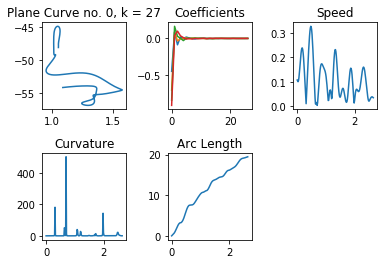

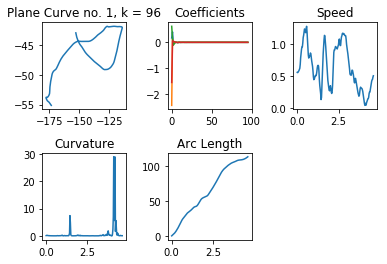

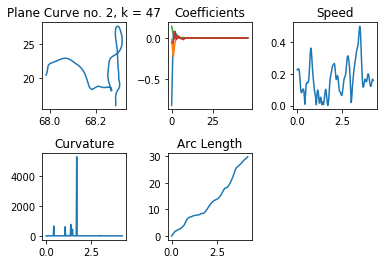

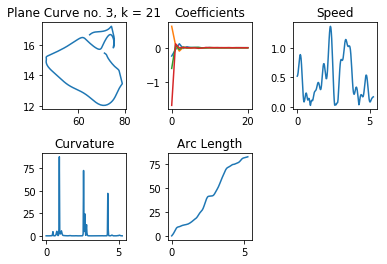

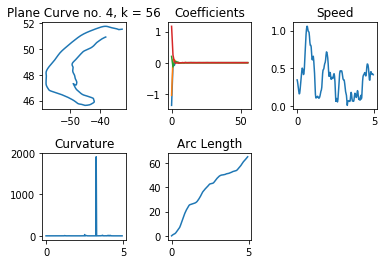

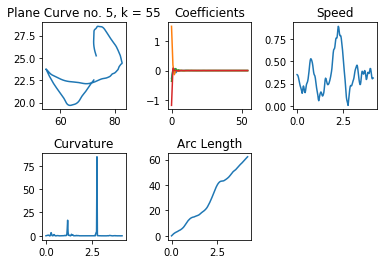

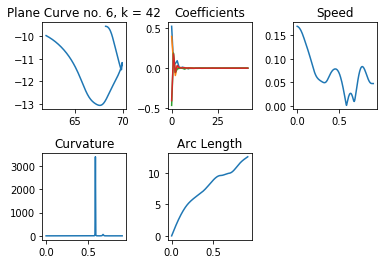

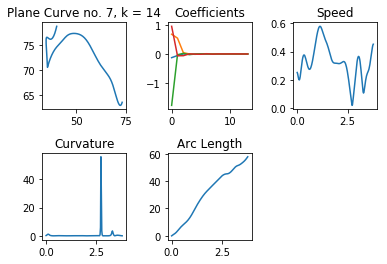

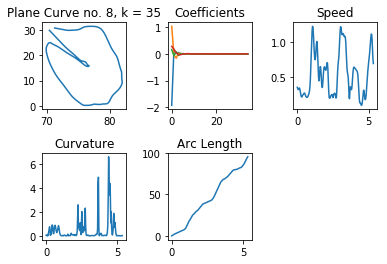

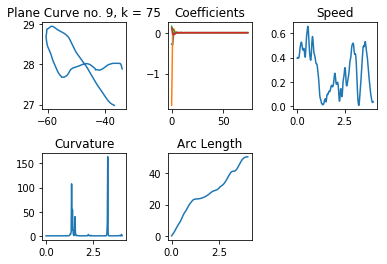

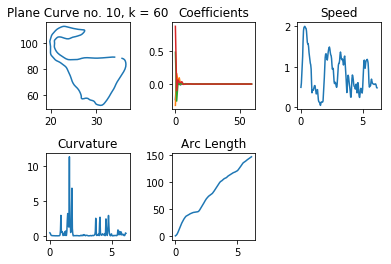

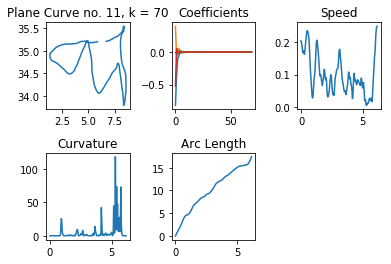

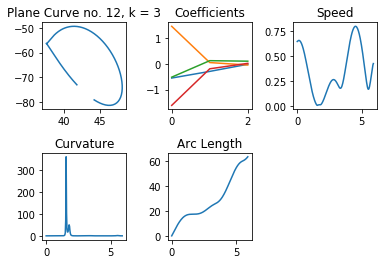

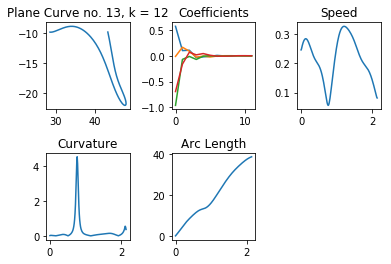

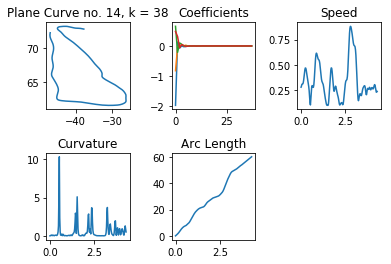

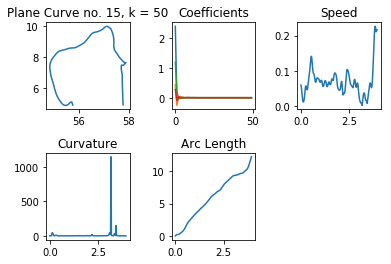

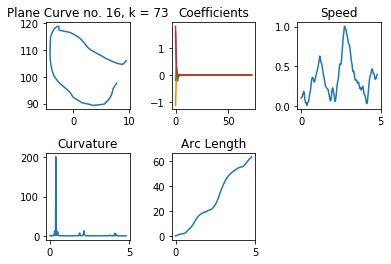

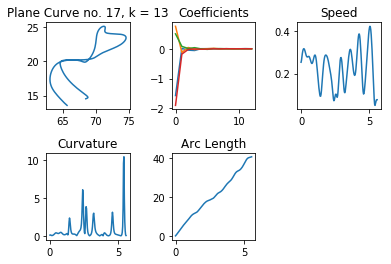

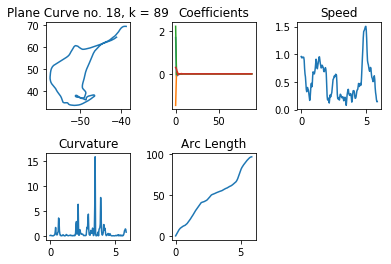

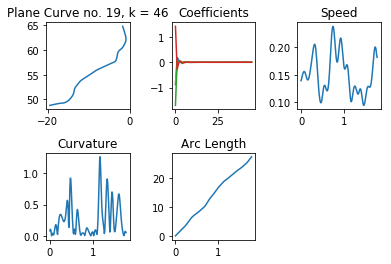

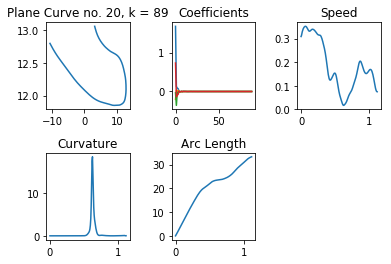

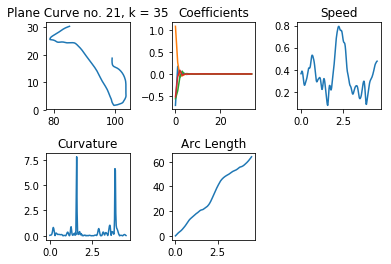

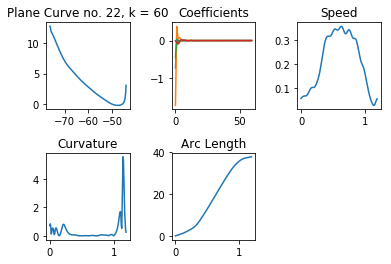

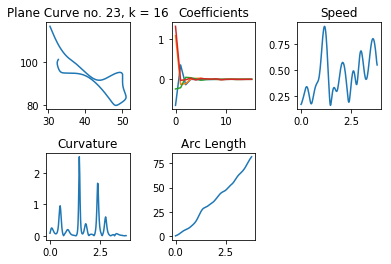

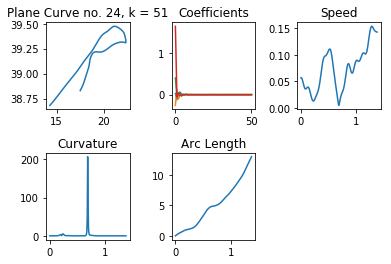

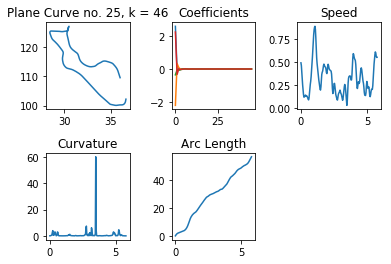

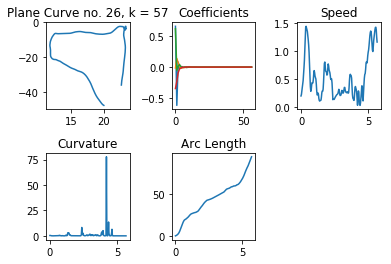

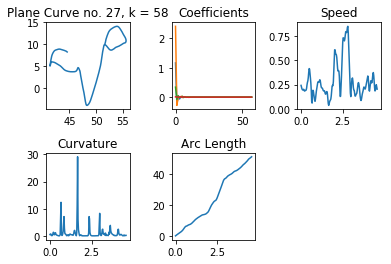

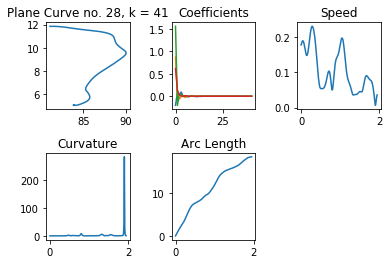

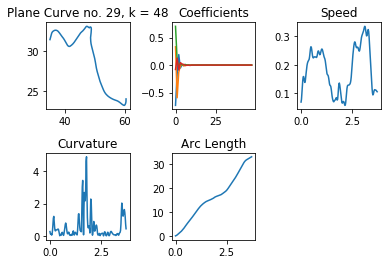

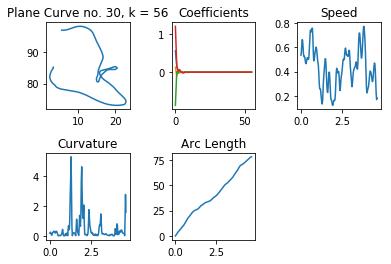

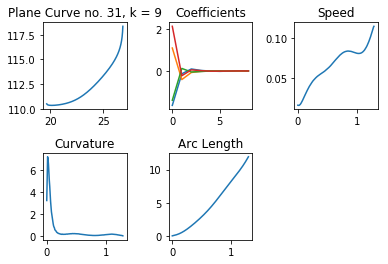

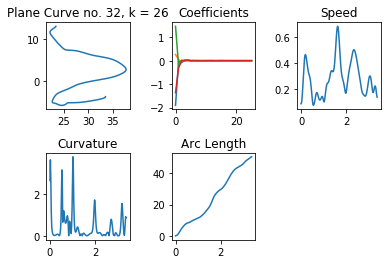

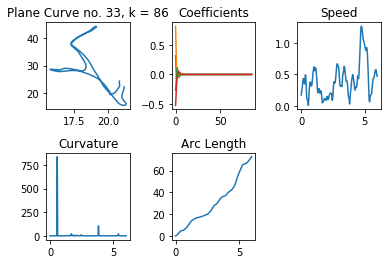

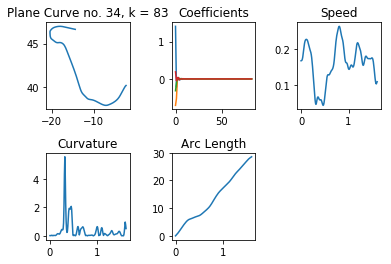

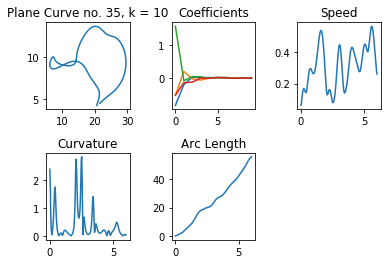

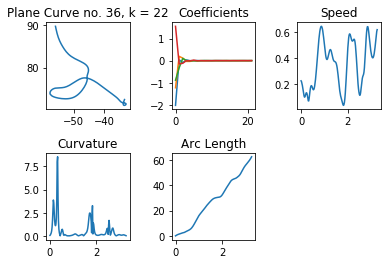

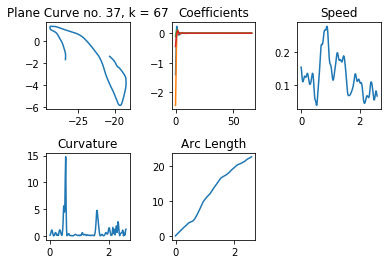

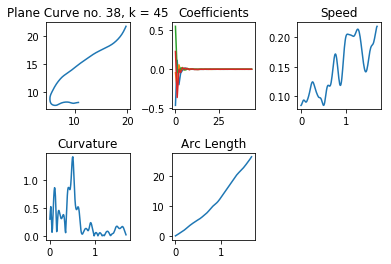

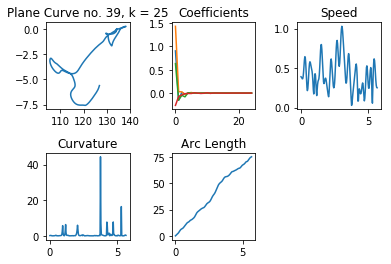

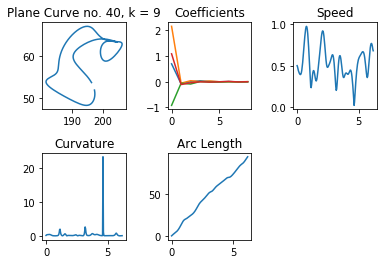

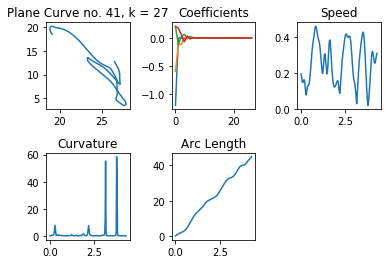

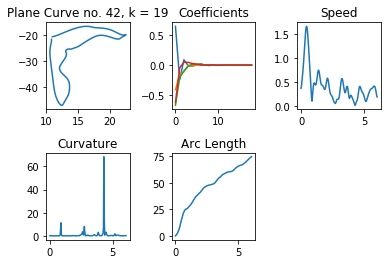

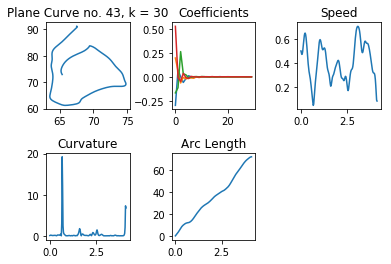

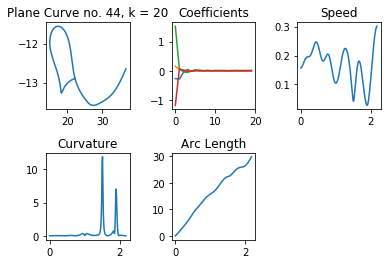

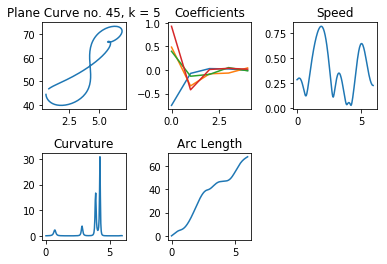

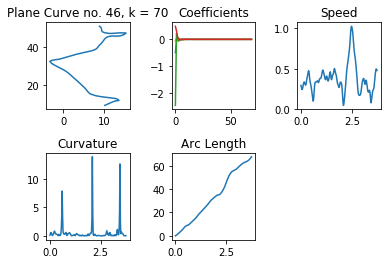

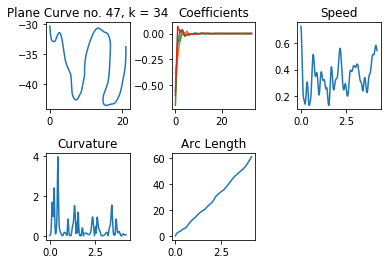

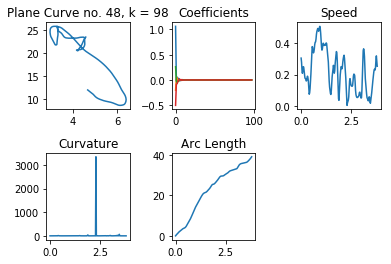

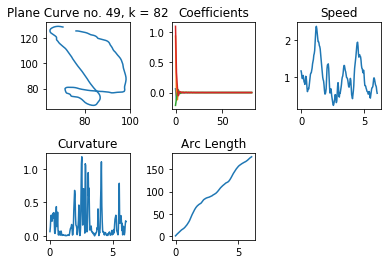

In [129]:
# Make sure the number of curves generated and captured here match
           #n  k    p
genNCurves(50, 100, 2.5)

               #n  start  stop  frame rate resolution  plot
captureNCurves(50, 0,     3,    60,        0.0001,        True)

In [117]:
def captureCurvCSV(n, time_start, time_stop, frame_rate, resolution, bool_plot):
    df_curv = pd.DataFrame() 
    for i in range(n):
        df_curv[i] = captureCurve(i, time_start, time_stop, frame_rate, resolution, plot = bool_plot)[0]['CURVATURE']
    # Export to CSV
    #summaryStats = df_curv.describe()
    #summaryStats = df_curv.describe()
    df_curv.to_csv('curvature.csv')

def captureSpeedCSV(n, time_start, time_stop, frame_rate, resolution, bool_plot):
    df_curv = pd.DataFrame() 
    for i in range(n):
        df_curv[i] = captureCurve(i, time_start, time_stop, frame_rate, resolution, plot = bool_plot)[0]['SPEED']
    # Export to CSV
    #summaryStats = df_curv.describe()
    #summaryStats = df_curv.describe()
    df_curv.to_csv('speed.csv')
    
def captureArcCSV(n, time_start, time_stop, frame_rate, resolution, bool_plot):
    df_curv = pd.DataFrame() 
    for i in range(n):
        df_curv[i] = captureCurve(i, time_start, time_stop, frame_rate, resolution, plot = bool_plot)[0]['ARCLENGTH']
    # Export to CSV
    #summaryStats = df_curv.describe()
    #summaryStats = df_curv.describe()
    df_curv.to_csv('arclength.csv')

In [120]:
captureCurvCSV(50,0,3,60, 0.0001, False)
captureSpeedCSV(50,0,3,60, 0.0001, False)
captureArcCSV(50,0,3,60, 0.0001, False)

# Generate Summary Statistics across N curves for each variables

In [121]:
N =10

def varStats (var_str):
    """
    Inputs: 
    >> string var_str: Variable (X, Y, SPEED, CURVATURE or ARCLENGTH) that we want to check summary statistics on
    
    Outputs:
    >> dataframe df: Dataframe with columns of summary statistics for that variable
    """
    df = pd.DataFrame(columns = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
    for i in range(N):
        curve_i = pd.read_csv("Curve Data/summary_stats_" + str(i) + ".csv")
        row = pd.DataFrame(curve_i[var_str]).T
        row.columns = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
        df = df.append(row)
    return df

allVarStats = pd.DataFrame(columns = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
for df in (varStats('X'), varStats('Y'), varStats('SPEED'), varStats('CURVATURE'). varStats('ARCLENGTH')):
    allVarStats = allVarStats.append(df)
    
allVarStats.to_csv('summary_stats_' + str(N) + '_curves.csv')

AttributeError: 'DataFrame' object has no attribute 'varStats'

In [ ]:
XStats = varStats('X')
YStats = varStats('Y')
spdStats = varStats('SPEED')
crvStats = varStats('CURVATURE')
arcStats = varStats('ARCLENGTH')